In [1]:
!pip install rasterio

In [2]:
!pip install 'h5py==2.10.0' --force-reinstall

  Using cached h5py-2.10.0-cp36-cp36m-manylinux1_x86_64.whl (2.9 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.19.5-cp36-cp36m-manylinux2010_x86_64.whl (14.8 MB)
ERROR: tensorflow 2.1.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.5.2 which is incompatible.
ERROR: tensorflow-gpu 2.1.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.5.2 which is incompatible.
ERROR: raiwidgets 0.2.2 has requirement lightgbm>=3.1.1, but you'll have lightgbm 2.3.0 which is incompatible.
ERROR: econml 0.12.0b1 has requirement shap~=0.38.1, but you'll have shap 0.34.0 which is incompatible.
ERROR: azureml-train-automl-runtime 1.30.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.5 which is incompatible.
ERROR: azureml-opendatasets 1.30.0 has requirement numpy<=1.19.0,>=1.16.0, but you'll have numpy 1.19.5 which is incompatible.
ERROR: azureml-opendatasets 1.30.0 has requirement scipy<=1.4.1,>=

In [2]:
!pip install folium

In [3]:
!pip install earthengine-api --upgrade

     |████████████████████████████████| 230 kB 4.8 MB/s eta 0:00:01
  Created wheel for earthengine-api: filename=earthengine_api-0.1.290-py3-none-any.whl size=260050 sha256=c305e130ae8c4ca0a612cab28a357c363fb8eb686410cd9c74d222fc9ba5e5f7
  Stored in directory: /home/azureuser/.cache/pip/wheels/3f/6d/58/12fbe21dbf39add27ec04616bfe306e67c741cf95845fa87a4
Successfully built earthengine-api
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 0.1.288
    Uninstalling earthengine-api-0.1.288:
      Successfully uninstalled earthengine-api-0.1.288


In [4]:
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [17]:
import azureml.core
from azureml.core import Experiment, Workspace, Dataset, Datastore, ScriptRunConfig, Model
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

import os
import shutil
import glob
from os.path import join
from sys import path

import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import metrics

import numpy as np
import rasterio as rio
import json

# check core SDK version number

print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.30.0


In [6]:
# make sure we have the most current version of github repo
%cd Satellite_ComputerVision
!git pull
%cd ..

/mnt/batch/tasks/shared/LS_root/mounts/clusters/mevans1/code/Users/mevans/Satellite_ComputerVision
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 156 (delta 114), reused 112 (delta 70), pack-reused 0
Receiving objects: 100% (156/156), 39.27 KiB | 59.00 KiB/s, done.
Resolving deltas: 100% (114/114), completed with 5 local objects.
From https://github.com/mjevans26/Satellite_ComputerVision
   013c69c..6c7949d  master     -> origin/master
Updating 013c69c..6c7949d
error: Your local changes to the following files would be overwritten by merge:
	utils/__pycache__/clouds.cpython-36.pyc
Please commit your changes or stash them before you merge.
Aborting
/mnt/batch/tasks/shared/LS_root/mounts/clusters/mevans1/code/Users/mevans


In [7]:
# attach our utilities folder to the path to import modules
path.append('/home/azureuser/cloudfiles/code/Users/mevans/Satellite_ComputerVision')

In [8]:
from utils.model_tools import get_model, make_confusion_matrix, weighted_bce
from utils.processing import get_training_dataset, normalize
from utils.prediction_tools import makePredDataset, make_array_predictions, get_img_bounds
from utils.clouds import basicQA

In [9]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
# get metadata about the workspace
print(ws.name, ws.location, ws.resource_group, sep='\t')
# list the registered datastores
ws.datastores

solar-compviz	eastus2	place


{'workspaceartifactstore': {
   "name": "workspaceartifactstore",
   "container_name": "azureml",
   "account_name": "solarcompviz6161005396",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'solardatafilestore': {
   "name": "solardatafilestore",
   "container_name": "gee-data",
   "account_name": "solarcompviz6161005396",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'workspaceblobstore': {
   "name": "workspaceblobstore",
   "container_name": "azureml-blobstore-20200d5f-4836-4a79-bf1c-7bd46e0d0c35",
   "account_name": "solarcompviz6161005396",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'workspacefilestore': {
   "name": "workspacefilestore",
   "container_name": "azureml-filestore-20200d5f-4836-4a79-bf1c-7bd46e0d0c35",
   "account_name": "solarcompviz6161005396",
   "protocol": "https",
   "endpoint": "core.windows.net"
 }}

In [10]:
# access our registered data share containing image data in this workspace
datastore = Datastore.get(workspace = ws, datastore_name = 'solardatafilestore')



In [11]:
experiment_name = 'solar-nc-cpk'
exp = Experiment(workspace = ws, name = experiment_name)

In [12]:
run_id = 'solar-nc-cpk_1625110549_258bbfea'

run = ws.get_run(run_id)

run.tags

model_name = 'solar'

In [ ]:
# if we haven't already registered our model
model = run.register_model(model_name= model_name,
                           tags=run.tags,
                           description = 'UNET model delineating anthropogenic change in pairs of Sentinel-2 imagery',
                           model_path='outputs/',
                           model_framework = 'Tensorflow',
                           model_framework_version= '2.0',
                           datasets = [('training', train_dataset), ('evaluation', eval_dataset), ('testing', test_dataset)])
print(model.name, model.id, model.version, sep='\t')

In [14]:
model = Model(ws, model_name)
model_path = model.get_model_path(model_name, _workspace = ws)

In [15]:
model_dir = Model.get_model_path(model_name)
weights_path = glob.glob(os.path.join(model_dir, '*.hdf5'))
model_path = glob.glob(os.path.join(model_dir, '*.h5'))
weights_path
model_path

['azureml-models/solar/1/outputs/unet256.h5']

In [21]:
# Define some global variabes

BANDS = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
RESPONSE = 'landcover'
FEATURES = BANDS + [RESPONSE]
print(FEATURES)
DEPTH = len(FEATURES)

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

METRICS = {
    'logits':[tf.keras.metrics.MeanSquaredError(name='mse'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
    'classes':[tf.keras.metrics.MeanIoU(num_classes=2, name = 'mean_iou')]
    }

['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'landcover']


In [22]:
def get_weighted_bce(y_true,y_pred):
  return weighted_bce(y_true, y_pred, 1)
# m = models.load_model(f'{model_path[0]}', custom_objects = {'get_weighted_bce': get_weighted_bce})
m = get_model(depth = len(BANDS), optim = OPTIMIZER, loss = get_weighted_bce, mets = METRICS, bias = None)
m.load_weights(f'{weights_path[0]}')

In [30]:
# Create mountcontext and mount the dataset
aoi = 'testpred1'

cpk_test_path = (datastore, f'CPK_solar/predict/{aoi}')

cpk_test_dataset = Dataset.File.from_files(path = [cpk_test_path])

testFiles = []

# open access to the mount point
with cpk_test_dataset.mount() as mount:

    # Get the mount point
    dataset_mount_folder = mount.mount_point
    print(dataset_mount_folder)

    for root, dirs, files in os.walk(dataset_mount_folder):
        for f in files:
            testFiles.append(join(root, f))

    predFiles = [x for x in testFiles if '.gz' in x]
    jsonFiles = [x for x in testFiles if '.json' in x]
    jsonFile = jsonFiles[0]
    predData = makePredDataset(predFiles, BANDS, one_hot = None)
    preds = make_array_predictions(imageDataset = predData, model = m, jsonFile = jsonFile)

/tmp/tmp6476mxvk
Downloaded path: /tmp/tmpzmdb3l64/34740d42-2c1c-41f0-bb5c-83d787600477/CPK_solar/predict/testpred1/raw_unet256_testpred1.json is different from target path: /tmp/tmpzmdb3l64/34740d42-2c1c-41f0-bb5c-83d787600477/raw_unet256_testpred1.json
{'projection': {'crs': 'EPSG:4326', 'affine': {'doubleMatrix': [8.983152841195215e-05, 0.0, -76.89435101617644, 0.0, -8.983152841195215e-05, 38.59836197040554]}}, 'patchDimensions': [256, 256], 'patchesPerRow': 5, 'totalPatches': 10}
Running predictions...
Downloaded path: /tmp/tmpzmdb3l64/34740d42-2c1c-41f0-bb5c-83d787600477/CPK_solar/predict/testpred1/raw_unet256_testpred1.tfrecord.gz is different from target path: /tmp/tmpzmdb3l64/34740d42-2c1c-41f0-bb5c-83d787600477/raw_unet256_testpred1.tfrecord.gz
10/10 [==============================] - 28s 3s/step
Writing patch 1...
Writing patch 2...
Writing patch 3...
Writing patch 4...
Writing patch 5...
Writing patch 6...
Writing patch 7...
Wr

In [25]:
# predFiles = [x for x in testFiles if '.gz' in x]
# predFiles

['/tmp/tmpcgvo7vsi/raw_unet256_testpred1.tfrecord.gz']

In [26]:
# jsonFiles = [x for x in testFiles if '.json' in x]
# jsonFiles
# jsonFile = jsonFiles[0]

In [ ]:
# predData = makePredDataset(predFiles, BANDS, one_hot = None)
# iterator = iter(predData)
# print(iterator.next())

In [ ]:
# preds = make_array_predictions(imageDataset = predData, model = m, jsonFile = jsonFile)

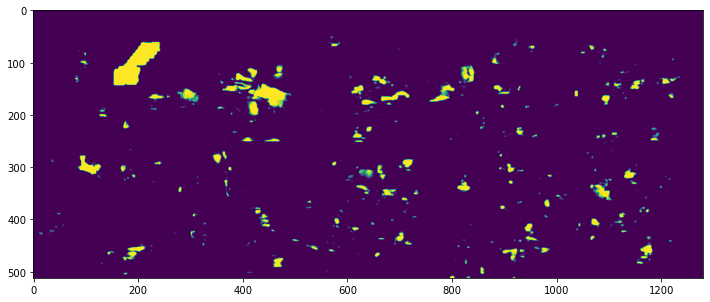

In [31]:
# We can visualize the predictions here in the notebook
from matplotlib import pyplot as plt
from matplotlib import colors

figure = plt.figure(figsize = (12,12))
# cmap = colors.ListedColormap(['#5dc5f1', '#50a886', '#3d6e1d', '#80e144', '#bafb85', '#d4a13e', "#e73522", "#9c9c9c", "#000000", "#706e22", "#e7e64b", "#fefc86", '#ad36ed'])
prob = preds[:, :, 0]
# cls = out_image[:, :, 0]

plt.imshow(prob)#, norm = colors.BoundaryNorm([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], cmap.N), cmap = cmap)

In [ ]:
# Folium setup.
import folium
print(folium.__version__)

# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer